In [1]:
# imports
import numpy as np
import skimage
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy 
from pylab import *
from scipy import signal
from scipy import *
import numpy as np
from PIL import Image
import os
import random

In [2]:
N_MATCHES = 300
s = 4
N_RANSAC = 1000
INLIER_THRESHOLD = 1

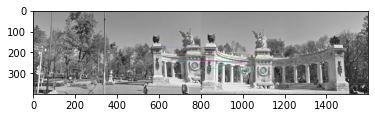

(<matplotlib.image.AxesImage at 0x1e0679aad90>, None)

In [3]:
img1 = cv2.imread('left.jpg',0) # queryImage
img2 = cv2.imread('right.jpg',0) # trainImage

# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L2)

# Match descriptors.
matches = bf.match(des1, des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Select top N matches
putatives = matches[:N_MATCHES]

# Draw first 10 matches.
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=2)

plt.imshow(img3),plt.show()

In [31]:
# Provided code for plotting inlier matches between two images
def plot_inlier_matches(ax, img1, img2, inliers):
    """
    Plot the matches between two images according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')

# constructs matrix A from lecture, projects locations from left image 
# onto locations in right image
def construct_A(l_homo_coords, r_homo_coords):
    zero_T = np.zeros(3)
    A = np.empty((8,9))
    for i in range(s):
        x_T = l_homo_coords[i]
        row_1 = np.hstack((zero_T, x_T, -1 * r_homo_coords[i][1] * x_T))
        row_2 = np.hstack((x_T, zero_T, -1 * r_homo_coords[i][0] * x_T))
        A[2*i] = row_1
        A[2*i+1] = row_2
    return A

# convert 2D homogeneous coords to regular 2D coords
def homo_to_norm(homo_coords):
    return np.array((homo_coords[0] / homo_coords[2], homo_coords[1] / homo_coords[2]))

# warp a point using a homography matrix
def warp_point(normal_coords, homo_matrix):
    # convert coordinates to homogenous coordinates
    homo_coords = np.array(normal_coords + (1,))
    # compute Hx, projected coordinates of homo_coords
    proj_homo_coords = np.matmul(homo_matrix, homo_coords)
    # convert projected homo coordinates back to normal coordinates
    return homo_to_norm(proj_homo_coords) 

# compute inliers and avg residuals for given homography
def compute_inliers(putatives, l_kps, r_kps, homo_matrix):
    num_inliers = 0
    total_residuals = 0.
    inliers = []
    # cycle through all putatives for inliers
    for i in range(len(putatives)):
        # normal coordinates for both points
        r_coords = r_kps[matches[i].trainIdx].pt
        l_coords = l_kps[matches[i].queryIdx].pt
        # warp point with homography matrix
        proj_l_coords = warp_point(l_coords, homo_matrix)
        # compute SSD between projected left coords and known right coords
        residual = np.sum((r_coords - proj_l_coords)**2)
        # if less than threshold, count it
        if residual < INLIER_THRESHOLD:
            num_inliers += 1
            total_residuals += residual
            # append inlier as 1D array of length 4 (leftcoords, rightcoords
            inliers.append(np.hstack((l_coords, r_coords)))    
    return np.array(inliers), total_residuals / num_inliers

# RANSAC PARAMETERS
def RANSAC(putatives, l_kps, r_kps):
    # our return values
    best_num_inliers = 0
    best_avg_inlier_residual = 0
    best_homo_matrix = np.empty((3,3))
    best_inliers = []
    
    # iterate N_RANSAC times
    for i in range(N_RANSAC):
        # draw s(4) points at random 
        matches = random.sample(putatives, s)
        # translate to homogeneous coordinates
        coords_left = np.array([np.array(l_kps[matches[i].queryIdx].pt + (1,)) for i in range(s)])
        coords_right = np.array([np.array(r_kps[matches[i].trainIdx].pt + (1,)) for i in range(s)])
        # construct matrix A as described in lecture
        A = construct_A(coords_left, coords_right)
        # find solution for homography matrix H
        U_, s_, v_ = np.linalg.svd(A)
        min_s_val = v_[len(v_)-1]
        homo_matrix = min_s_val.reshape((3,3))
        # use H to compute inliers
        inliers, avg_residual = compute_inliers(putatives, l_kps, r_kps, homo_matrix)
        num_inliers = len(inliers)
        # update best homography
        if num_inliers > best_num_inliers:
            best_num_inliers = num_inliers
            best_avg_inlier_residual = avg_residual
            best_homo_matrix = homo_matrix
            best_inliers = inliers
    return best_inliers, best_avg_inlier_residual, best_homo_matrix

In [32]:
best_inliers, best_avg_inlier_residual, best_homo_matrix = RANSAC(putatives, kp1, kp2)
print("Best average inlier residual: " + str(best_avg_inlier_residual))
print("Number of inliers: " + str(len(best_inliers)))

Best average inlier residual: 0.33840539699650996
Number of inliers: 60


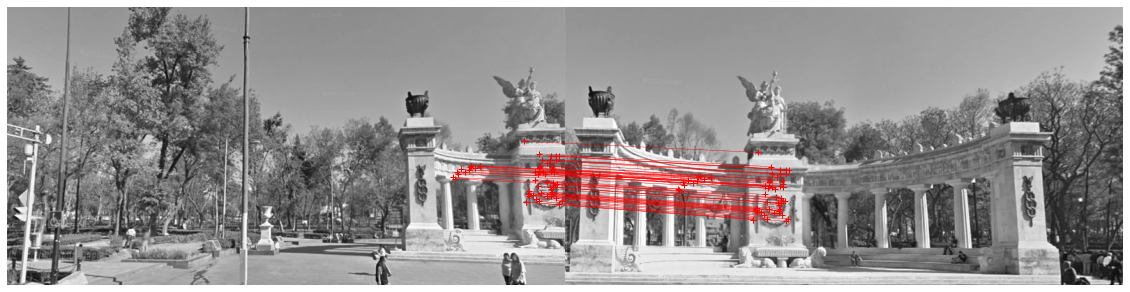

In [33]:
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, best_inliers)

[[ -917.42287059  -235.14304203]
 [  337.86882251    44.71745087]
 [-2273.01131018   761.63530067]
 [  316.5616516    451.43871256]]
(398, 800)


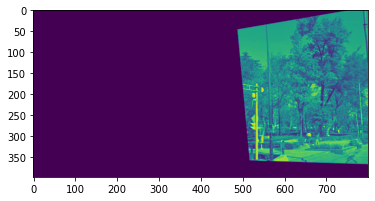

In [35]:
# calculate dims of transformed image
max_y, max_x = np.array(img1).shape
corner_points = [(0, 0), (max_x, 0), (0, max_y),  (max_x, max_y)]
transformed_coords = np.array([warp_point(corner_point, best_homo_matrix) for corner_point in corner_points])
print(transformed_coords)

tf = skimage.transform.ProjectiveTransform(matrix=best_homo_matrix)
#warped_img_1 = skimage.transform.warp(img1, tf, output_shape=())

print(warped_img_1.shape)

plt.imshow(warped_img_1)
plt.show()

In [ ]:
# ##############################################
# ### Provided code - nothing to change here ###
# ##############################################
# """
# Harris Corner Detector
# Usage: Call the function harris(filename) for corner detection
# Reference   (Code adapted from):
#              http://www.kaij.org/blog/?p=89
#              Kai Jiang - Harris Corner Detector in Python
             
# """

# def harris(filename, min_distance = 10, threshold = 0.1):
#     """
#     filename: Path of image file
#     threshold: (optional)Threshold for corner detection
#     min_distance : (optional)Minimum number of pixels separating 
#      corners and image boundary
#     """
#     im = np.array(Image.open(filename).convert("L"))
#     harrisim = compute_harris_response(im)
#     filtered_coords = get_harris_points(harrisim,min_distance, threshold)
#     plot_harris_points(im, filtered_coords)

# def gauss_derivative_kernels(size, sizey=None):
#     """ returns x and y derivatives of a 2D 
#         gauss kernel array for convolutions """
#     size = int(size)
#     if not sizey:
#         sizey = size
#     else:
#         sizey = int(sizey)
#     y, x = mgrid[-size:size+1, -sizey:sizey+1]
#     #x and y derivatives of a 2D gaussian with standard dev half of size
#     # (ignore scale factor)
#     gx = - x * exp(-(x**2/float((0.5*size)**2)+y**2/float((0.5*sizey)**2))) 
#     gy = - y * exp(-(x**2/float((0.5*size)**2)+y**2/float((0.5*sizey)**2))) 
#     return gx,gy

# def gauss_kernel(size, sizey = None):
#     """ Returns a normalized 2D gauss kernel array for convolutions """
#     size = int(size)
#     if not sizey:
#         sizey = size
#     else:
#         sizey = int(sizey)
#     x, y = mgrid[-size:size+1, -sizey:sizey+1]
#     g = exp(-(x**2/float(size)+y**2/float(sizey)))
#     return g / g.sum()

# def compute_harris_response(im):
#     """ compute the Harris corner detector response function 
#         for each pixel in the image"""
#     #derivatives
#     gx,gy = gauss_derivative_kernels(3)
#     imx = signal.convolve(im,gx, mode='same')
#     imy = signal.convolve(im,gy, mode='same')
#     #kernel for blurring
#     gauss = gauss_kernel(3)
#     #compute components of the structure tensor
#     Wxx = signal.convolve(imx*imx,gauss, mode='same')
#     Wxy = signal.convolve(imx*imy,gauss, mode='same')
#     Wyy = signal.convolve(imy*imy,gauss, mode='same')   
#     #determinant and trace
#     Wdet = Wxx*Wyy - Wxy**2
#     Wtr = Wxx + Wyy
#     return Wdet / Wtr

# def get_harris_points(harrisim, min_distance=10, threshold=0.1):
#     """ return corners from a Harris response image
#         min_distance is the minimum nbr of pixels separating 
#         corners and image boundary"""
#     #find top corner candidates above a threshold
#     corner_threshold = max(harrisim.ravel()) * threshold
#     harrisim_t = (harrisim > corner_threshold) * 1    
#     #get coordinates of candidates
#     candidates = harrisim_t.nonzero()
#     coords = [ (candidates[0][c],candidates[1][c]) for c in range(len(candidates[0]))]
#     #...and their values
#     candidate_values = [harrisim[c[0]][c[1]] for c in coords]    
#     #sort candidates
#     index = argsort(candidate_values)   
#     #store allowed point locations in array
#     allowed_locations = zeros(harrisim.shape)
#     allowed_locations[min_distance:-min_distance,min_distance:-min_distance] = 1   
#     #select the best points taking min_distance into account
#     filtered_coords = []
#     for i in index:
#         if allowed_locations[coords[i][0]][coords[i][1]] == 1:
#             filtered_coords.append(coords[i])
#             allowed_locations[(coords[i][0]-min_distance):(coords[i][0]+min_distance),
#                 (coords[i][1]-min_distance):(coords[i][1]+min_distance)] = 0               
#     return filtered_coords

# def plot_harris_points(image, filtered_coords):
#     """ plots corners found in image"""
#     figure()
#     gray()
#     imshow(image)
#     plot([p[1] for p in filtered_coords],[p[0] for p in filtered_coords],'r*')
#     axis('off')
#     show()
    
# # Usage:
# # fig, ax = plt.subplots(figsize=(20,10))
# # plot_inlier_matches(ax, img1, img2, computed_inliers)

# # code modified from: https://stackoverflow.com/questions/52920499/find-all-points-within-distance-1-of-specific-point-in-2d-numpy-matrix
# def get_neighborhood_vector(array, r, c, dist=1):
#     m, n = array.shape
#     vector = []
#     # loop over possible locations
#     for i in range(-dist, dist + 1): 
#         for j in range(-dist, dist + 1): 
#             # check if location is within boundary
#             if 0 <= r + i < m and 0 <= c + j < n:
#                 vector.append(array[r + i][c + j])
#     return vector


# def get_harris_results(rel_path):
#     descriptors = []
#     image_path = os.path.join(os.getcwd(), rel_path)
#     image = np.array(Image.open(image_path).convert("L"))
#     float_image = image / 255
#     harris_response = compute_harris_response(float_image)
#     harris_points = get_harris_points(harris_response)
#     for point in harris_points:
#         neighborhood_vector = get_neighborhood_vector(harris_response, point[0], point[1], NEIGHBORHOOD_DISTANCE)
#         if len(neighborhood_vector) == NEIGHBORHOOD_SIZE:
#             descriptors.append(neighborhood_vector)
#     return float_image, harris_response, harris_points, np.array(descriptors)


# image_left, response_left, points_left, descriptors_left = get_harris_results("left.jpg")
# image_right, response_right, points_right, descriptors_right = get_harris_results("right.jpg")

# print(descriptors_left.shape)
# print(descriptors_right.shape)

# # matching code 
# bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
# matches = bf.match(descriptors_left, descriptors_right)
# matches = sorted(matches, key = lambda x:x.distance)

# image = cv2.drawMatches(image_left, points_left, image_right, points_right, matches[:10], flags=2)
# plt.imshow(image),plt.show()